# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting
### Due Date: 11:59pm on Wednesday, Apr. 8, 2020

This is a template solution file. 
Please feel free to use this for the base of your report. 

## Recovering HDR Radiance Maps (50 pts)

We start by loading in necessary libraries used for this section of the problem.

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
from os import path
import math

# Third-Party Imports
from PIL import Image
from PIL.ExifTags import TAGS

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import random
from scipy.interpolate import griddata
from scipy.sparse import lil_matrix
import skimage
import skimage.feature
import skimage.viewer
import time

# local imports
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_hdr_image_linear, display_hdr_image, display_log_irradiances
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter
from utils.meta import TODO

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Viewer requires Qt


### ### Data collection (10 points)

1. Find a good scene to photograph. The scene should have a flat surface to place your spherical mirror on. Either indoors or outdoors will work.
<img src="images/project_4/background.jpg" alt="Drawing" style="width: 400px;"/>
2. Find a fixed, rigid spot to place your camera. A tripod is best, but you can get away with less. I used the back of a chair to steady my phone when taking my images.
3. Place your spherical mirror on a flat surface, and make sure it doesn't roll by placing a cloth/bottle cap/etc under it. Make sure the sphere is not too far away from the camera -- it should occupy at least a 256x256 block of pixels.
<img src="images/project_4/background_with_ball.jpg" alt="Drawing" style="width: 400px;"/>
4. Photograph the spherical mirror using at least three different exposure times. Make sure the camera does not move too much (slight variations are OK, but the viewpoint should generally be fixed). For best results, your exposure times should be at least 4 times longer and 4 times shorter (±2 stops) than your mid-level exposure (e.g. if your mid-level exposure time is 1/40s, then you should have at least exposure timess of 1/10s and 1/160s; the greater the range the better). Make sure to record the exposure times.
5. Remove the mirror from the scene, and from the same viewpoint as the other photographs, take another picture of the scene at a normal exposure level (most pixels are neither over- or under-exposed). This will be the image that you will use for object insertion/compositing (the "background" image).
6. After you copy all of the images from your camera/phone to your computer, load the spherical mirror images (from step 4) into your favorite image editor and crop them down to contain only the sphere.
<img src="images/project_4/cropped.jpg" alt="Drawing" style="width: 400px;"/>
7. Small alignment errors may occur (due to camera motion or cropping). One way to fix these is through various alignment procedures, but for this project, we won't worry about these errors. If there are substantial differences in camera position/rotation among the set of images, re-take the photographs.

In [3]:
def display_images(img_cnt, imgs, titles, datatypes=None):
    
    assert img_cnt == len(imgs)
    assert img_cnt == len(titles)
        
    fig, axes = plt.subplots(1,img_cnt, figsize=(25,25))

    for i in range(img_cnt):
        datatype = 'double'
        if(datatypes is not None):
            assert img_cnt == len(datatypes)
            datatype = datatypes[i]
        axes[i].imshow(imgs[i].astype(datatype),cmap='gray') 
        axes[i].set_title(titles[i], fontsize=15)
        
def get_field_tag (exif,field) :
    for (k,v) in exif.items():
        if TAGS.get(k) == field:
            return v
    return None     

In [16]:
# Replace this with actual file path!
low_exposure_mirror_ball_image_file = "images/inputs/IMG_3_1_125.JPG"
mid_exposure_mirror_ball_image_file = "images/inputs/IMG_3_1_25.JPG"
high_exposure_mirror_ball_image_file = "images/inputs/IMG_3_1_5.JPG"

low_exposure_exif = Image.open(low_exposure_mirror_ball_image_file)._getexif()
mid_exposure_exif = Image.open(mid_exposure_mirror_ball_image_file)._getexif()
high_exposure_exif = Image.open(high_exposure_mirror_ball_image_file)._getexif()


# Extract exposure values for each images
low_exposure = get_field_tag(low_exposure_exif, "ExposureTime")
mid_exposure = get_field_tag(mid_exposure_exif, "ExposureTime")
high_exposure = get_field_tag(high_exposure_exif, "ExposureTime")

print("File: ", low_exposure_mirror_ball_image_file, " Exposure: ", low_exposure)
print("File: ", mid_exposure_mirror_ball_image_file, " Exposure: ", mid_exposure)
print("File: ", high_exposure_mirror_ball_image_file, " Exposure: ", high_exposure)


# These images will be used for LDR mergings
low_exposure_mirror_ball_image = read_image(low_exposure_mirror_ball_image_file)
mid_exposure_mirror_ball_image = read_image(mid_exposure_mirror_ball_image_file)
high_exposure_mirror_ball_image = read_image(high_exposure_mirror_ball_image_file)


File:  images/inputs/IMG_3_1_125.JPG  Exposure:  (1, 125)
File:  images/inputs/IMG_3_1_25.JPG  Exposure:  (1, 25)
File:  images/inputs/IMG_3_1_5.JPG  Exposure:  (1, 5)


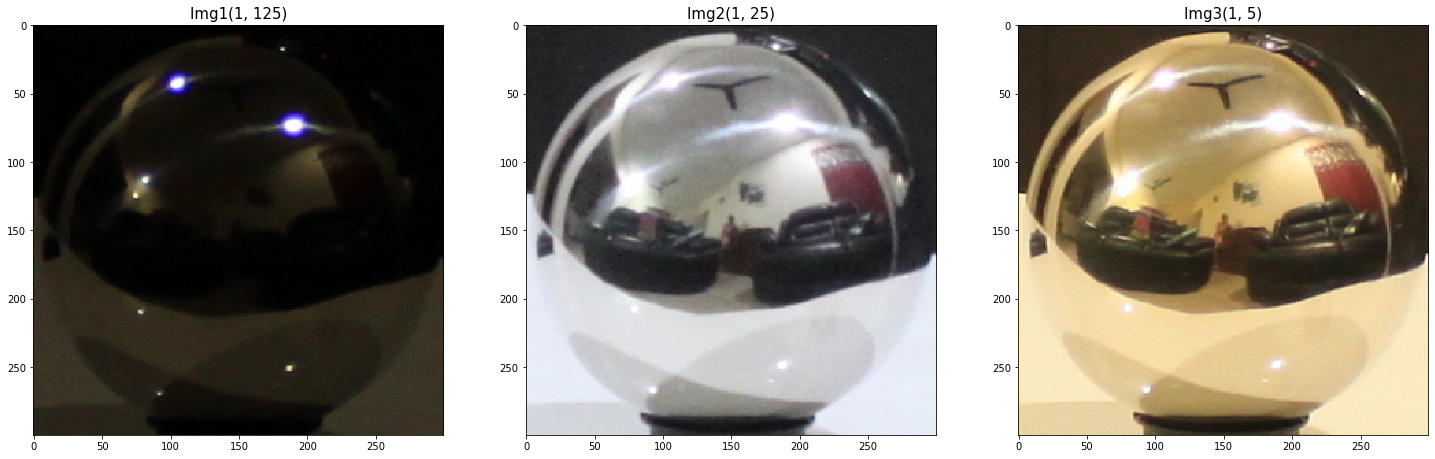

In [188]:
# resize mirror ball images:
N = 300

low_exposure_mirror_ball_image = cv2.resize(low_exposure_mirror_ball_image, (N, N))
mid_exposure_mirror_ball_image = cv2.resize(mid_exposure_mirror_ball_image, (N, N))
high_exposure_mirror_ball_image = cv2.resize(high_exposure_mirror_ball_image, (N, N))
    
ldr_images = np.stack((
                       low_exposure_mirror_ball_image, 
                       mid_exposure_mirror_ball_image, 
                       high_exposure_mirror_ball_image
                      ))

display_images(3, ldr_images, ['Img1'+str(low_exposure), 
                               'Img2'+str(mid_exposure), 
                               'Img3' + str(high_exposure)])

exposures = [np.round(low_exposure[0]/low_exposure[1],4), \
             np.round(mid_exposure[0]/mid_exposure[1],4), \
             np.round(high_exposure[0]/high_exposure[1],4)]


### Naive LDR merging (10 points)

After collecting data, load the cropped images, and resize them to all be square and the same dimensions (e.g. cv2.resize(ldr,(N,N)) N is the new size). Either find the exposure times using the EXIF data (usually accessible in the image properties, or via matlab's imfinfo), or refer to your recorded exposure times. To put the images in the same intensity domain, divide each by its exposure time (e.g. ldr1_scaled = ldr1 / exposure_time1). After this conversion, all pixels will be scaled to their approximate value if they had been exposed for 1s.

The easiest way to convert your scaled LDR images to an HDR is simply to average them. Create one of these for comparison to your later results. 

To save the HDR image, use given write_hdr_image function.
To visualize HDR image, use given display_hdr_image function.

In [189]:
def compare_hdr(hdr1, hdr2, title1='HDR1', title2='HDR2'):
    display_hdr_image(hdr1)
    display_hdr_image(hdr2)
    
    print(title1, " min: ", np.ndarray.min(hdr1), " max: ", np.ndarray.max(hdr1))
    print(title2, " min: ", np.ndarray.min(hdr2), " max: ", np.ndarray.max(hdr2))
    

In [190]:
def calculate_log_irradiances(ldr_images: np.ndarray, exposures: list) -> (np.ndarray):
    
    N, H, W, C = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)

    '''
        ln Ei = ln(Zij) - ln (delta tj)
    '''
    log_exposures = np.log(exposures)
    
    pixel_value_max = np.ndarray.max(ldr_images)
    normalize_z = False
    
    #if (pixel_value_max > 1.0):
    #    normalize_z = True

    log_irradiances = np.zeros((N,H,W,C))
    
    for n in range(N):
        ldr = ldr_images[n].copy()
        for y in range(H):
            for x in range(W):
                for c in range(C): 
                    z = int(np.round(ldr[y][x][c]*255,0))
                    log_irradiances[n][y][x][c] = np.log(z) - log_exposures[n]
    
    return log_irradiances


In [191]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
            
    '''
    N, H, W, C = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)
    
    # TODO: Implement ldr_images + exposures -> HDR image function here
    # np_exposures = N, shaped array
    ldr_images_scaled = np.ndarray((N, H, W, C))
    hdr_image = np.zeros((H,W,C))
    
    for i in range(N):
        ldr_images_scaled[i] = ldr_images[i]/exposures[i]
        hdr_image +=  ldr_images_scaled[i]
        
    hdr_image = hdr_image/N
    
    h, w, c = hdr_image.shape
    
    log_irradiances = calculate_log_irradiances(ldr_images, exposures)
    
    print("HDR min: ", hdr_image.min(), " max:", hdr_image.max())
    print("Log Irrandiances min: ", log_irradiances.min(), " max:", log_irradiances.max())
    
    return hdr_image, log_irradiances



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HDR min:  0.6751634379227957  max: 51.66450723012289
Log Irrandiances min:  -inf  max: 10.369577282460728


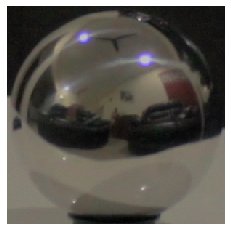

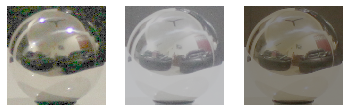

In [192]:
# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/my_naive_hdr.hdr')

# display HDR image
display_hdr_image(naive_hdr_image)

# display log irradiance image
display_log_irradiances(naive_log_irradiances)


### LDR merging without under- and over-exposed regions (10 points)

The naive method has an obvious limitation: if any pixels are under- or over-exposed, the result will contain clipped (and thus incorrect) information. A simple fix is to find these regions (e.g. a pixel might be considered over exposed if its value is less than 0.02 or greater than 0.98, assuming [0,1] images), and exclude them from the averaging process. Another way to think about this is that the naive method is extended using a weighted averaging procedure, where weights are 0 if the pixel is over/under-exposed, and 1 otherwise. Note that with this method, it might be the case that for a given pixel it is never properly exposed (i.e. always either above or below the threshold in each exposure). 

There are perhaps better methods that achieve similar results but don't require a binary weighting. For example, we could create a weighting function that is small if the input (pixel value) is small or large, and large otherwise, and use this to produce an HDR image. In python, such a function can be created with: 

w = lambda z: float(128-abs(z-128))

assuming pixel values range in [0,255].


#### Weighted Filter

In [441]:
def rescale(ldr: np.ndarray, new_max : float):
    curr_max = ldr.max()
    ldr_rescaled = (ldr/curr_max)*new_max
                
    return ldr_rescaled

In [442]:
def make_hdr_weighted_filter(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
    '''
    N, H, W, C = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)
    
    ldr_images_weighted = np.ndarray((N, H, W, C))
    hdr_image = np.zeros((H,W,C))
    
    w_func = lambda z: float(128-abs(z-128))
    w_list = []
    
    for n in range(N):
        # scaled
        ldr = ldr_images[n].copy()/exposures[n]
        max_val = ldr.max()
        print("LDR min: ",ldr.min(), " max: ", ldr.max())
        
        weights = np.zeros((3,1))
        
        for y in range(H):
            for x in range(W):
                z = ldr[y][x].max()
                w =  w_func(z)
                for c in range(C):
                    # ignore underexposed and overexposed
                    if(ldr[y,x,c] > 5 or ldr[y,x,c] < 250):
                        ldr[y,x,c] *= w
                        weights[c] += w
                    else:
                        ldr[y][x][c] = 0
                        
        ldr_T = np.transpose(ldr)
        
        ldr_T[0] /= weights[0]
        ldr_T[1] /= weights[1]
        ldr_T[2] /= weights[2]
        
        ldr_images_weighted[n] = rescale(np.transpose(ldr_T),249)
        hdr_image +=  ldr_images_weighted[n] 
        
    hdr_image = hdr_image/N
    print("HDR min: ", hdr_image.min(), " max:", hdr_image.max())
    
    log_irradiances = calculate_log_irradiances(ldr_images_weighted, exposures)
    print("Log Irrandiances min: ", log_irradiances.min(), " max:", log_irradiances.max())
    
    return hdr_image, log_irradiances


LDR min:  0.0  max:  124.99999
LDR min:  1.3812158  max:  25.0
LDR min:  0.15690196  max:  5.0
HDR min:  0.8752005287290862  max: 248.95638020833334


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Log Irrandiances min:  -inf  max: 15.887030178925436


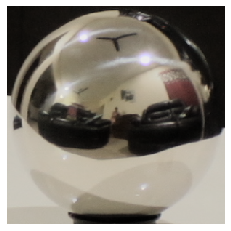

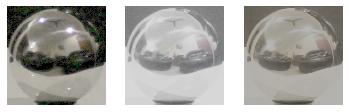

In [392]:
# get HDR image, log irradiance
filtered_hdr_image, filtered_log_irradiances = make_hdr_weighted_filter(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(filtered_hdr_image, 'images/outputs/my_filtered_hdr.hdr')

# display HDR image
display_hdr_image(filtered_hdr_image)

# display log irradiance image
display_log_irradiances(filtered_log_irradiances)

### LDR merging and response function estimation (15 points)

Nearly all cameras apply a non-linear function to recorded raw pixel values in order to better simulate human vision. In other words, the light incoming to the camera (radiance) is recorded by the sensor, and then mapped to a new value by this function. This function is called the film response function, and in order to convert pixel values to true radiance values, we need to estimate this response function. Typically the response function is hard to estimate, but since we have multiple observations at each pixel at different exposures, we can do a reasonable job up to a missing constant. 

The method we will use to estimate the response function is outlined in this paper. Given pixel values Z at varying exposure times t, the goal is to solve for g(Z) = ln(R*t) = ln(R)+ln(t). This boils down to solving for R (irradiance) since all other variables are known. By these definitions, g is the inverse, log response function. The paper provides code to solve for g given a set of pixels at varying exposures (we also provide gsolve in utils). Use this code to estimate g for each image channel (r/g/b). Then, recover the HDR image using equation 6 in the paper. 

#### Some hints on using gsolve:
  - When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (100 or so can suffice), but make sure all pixel locations are the same for each exposure.
  - The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method, i.e. w = lambda z: float(128-abs(z-128))).
  - Try different lambda values for recovering g. Try lambda=1 initially, then solve for g and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.
  - Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log radiance values, so make sure to exponentiate the result and save absolute radiance.

In [297]:
def collect_sample_pixels(images:  np.ndarray, sample_size: int=100):
    
    N, H, W, C = images.shape
    
    pixel_range = H*W
    
    p_sample_list = []
    
    center_i = int(H/2)
    center_j = int(W/2)
    
    radius = center_i
    
    for p in range(sample_size):
        outside_circle = True
        while (outside_circle):
            i = random.randrange(0, H)
            j = random.randrange(0, W)
            distance = math.sqrt( ( i-center_i)**2 + (j-center_j)**2 ) 
            if (distance < radius):
                outside_circle = False
                p_sample_list.append((i,j))
        
    return p_sample_list


In [273]:
def calculate_log_irradiances_with_gz(ldr_images: np.ndarray, exposures: list, \
                              l : float=1.0, plot_g : bool=False) -> (np.ndarray):
    
    N, H, W, C = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)
    assert H == W
    
    sample_size = 100
    p_sample_list = collect_sample_pixels(ldr_images, sample_size)
        
    B = np.log(exposures)
    w_func = lambda z: float(128-abs(z-128))
    
    log_irradiances = np.zeros((N,H,W,C))
    
    g = np.zeros((C,256))
    
    for n in range(N):
        print(str(n), " LDR min: ", ldr_images[n].min(), " max: ", ldr_images[n].max())
    
    print("Lamda value: ", str(l))
    
    for c in range(C):
        Z = np.zeros((N,sample_size))
        Z.dtype = 'uint8'
        cnt=0
        for n in range(N):
            for p in p_sample_list:
                (i,j) = p
                z = ldr_images[n][i][j][c]
                Z[n][cnt] = int(z * 255)
                cnt += 1
        
        g_c, lE_c = gsolve(Z, B, l, w_func)

        g[c] = g_c
    
    N, NG = g.shape
    labels = ['R', 'G', 'B']
    plt.figure()
    for n in range(N):
        plt.plot(range(NG), estimated_g[n], label=labels[n])
    plt.gca().legend(('R', 'G', 'B'))

    '''
        As per Eq 6 in paper (with smoothing)
            ln Ei = Sum w(Zij)(g(Zij) - ln delta tj) / Sum w(Zij) 
        where  0 < i < number_of_pixels ,0 < j < N
        
        # Denominator - sum of weights will be returned to the calling function)
    '''
    weights = np.zeros((H,W,C))
    for n in range(N):
        for y in range(H):
            for x in range(W):
                for c in range(C):
                    z = int(ldr_images[n][y][x][c]*255)
                    w = w_func(z)
                    g_z = g[c][z]
                    log_irradiances[n][y][x][c] = w * (g_z - B[n])
                    weights[y][x][c] += w
                
    print("Log Irradiances min: ", log_irradiances.min(), " max:", log_irradiances.max())
    
    return log_irradiances, g, weights


In [274]:
def make_hdr_estimation(ldr_images: np.ndarray, exposures: list, lambda_l: float=1.0)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be run with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N,
        l: Number
        W: function that takes int and returns float
    
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)
    
    
    # implement HDR estimation using gsolve
    log_irradiances, g, weights = calculate_log_irradiances_with_gz(ldr_images, exposures, lambda_l)
    
    '''
      As per Eq 6 in paper (with smoothing)
            ln Ei = Sum w(Zij)(g(Zij) - ln delta tj) / Sum w(Zij)
            where  0 < i < number_of_pixels ,0 < j < N
    '''    
    hdr_image = np.zeros((H,W,C))
    log_irradiance = np.zeros((H,W,C))
    for y in range(H):
        for x in range(W):
            for c in range(C):
                for n in range(N):
                    log_irradiance[y][x][c] += log_irradiances[n][y][x][c]
                    
                # this is Log value, we need to take exp(..)
                log_irradiance[y][x][c] /= weights[y,x,c]
                hdr_image[y][x][c] = np.exp(log_irradiance[y][x][c])
                            
    g_per_exposures = g
    
    return hdr_image, log_irradiances, g_per_exposures



0  LDR min:  0.0  max:  1.0
1  LDR min:  0.05524863  max:  1.0
2  LDR min:  0.031380393  max:  1.0
Lamda value:  110
Log Irradiances min:  0.0  max: 618.0241583832913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


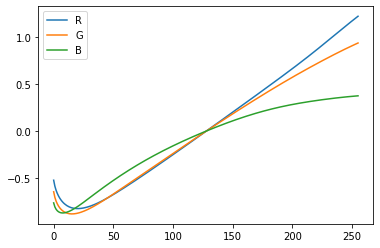

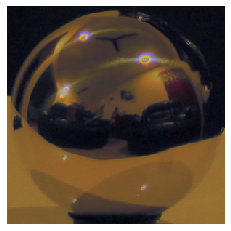

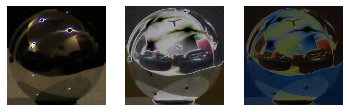

In [275]:
lambda_l=110

# get HDR image, log irradiance
estimated_hdr_image, estimated_log_irradiance, estimated_g = make_hdr_estimation(ldr_images, exposures, lambda_l)

# write HDR image to directory
write_hdr_image(estimated_hdr_image, 'images/outputs/my_estimated_hdr.hdr')

# display HDR image
display_hdr_image(estimated_hdr_image)

# display log irradiance image
display_log_irradiances(estimated_log_irradiance)

#time.sleep(10)
    

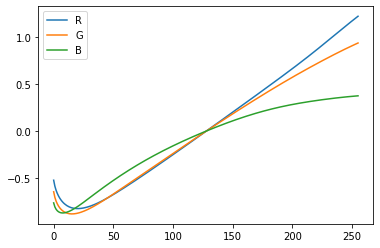

In [265]:
# display G function for each intensity values
N, NG = estimated_g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(range(NG), estimated_g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

#### Irradiance Discussion

In [298]:
sample_size=25
samples = collect_sample_pixels(estimated_log_irradiance, sample_size)

log_irradiances = np.zeros((N, sample_size))
pixel_values = np.zeros((N, sample_size))

print("Shape: ", log_irradiances.shape)

labels = ['Low', 'Medium', 'High']
x=0
for p in samples:
    i,j = p
    for n in range(N):
      #  print(x)
        log_irradiances[n][x] = estimated_log_irradiance[n][i][j][0]
        pixel_values[n][x] = ldr_images[n][i][j][0]
        
    x += 1

Shape:  (3, 25)


Text(0.5, 1.0, 'Plotting logIrradiances')

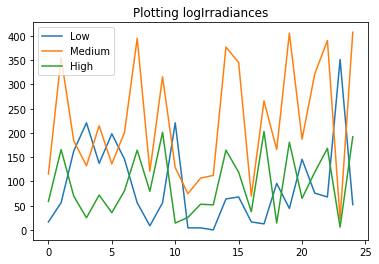

In [302]:
for n in range(N):
    plt.plot(range(sample_size), log_irradiances[n], label=labels[n])
plt.gca().legend(('Low', 'Medium', 'High'))

plt.title('Plotting logIrradiances')


Text(0.5, 1.0, 'Plotting pixel values(z)')

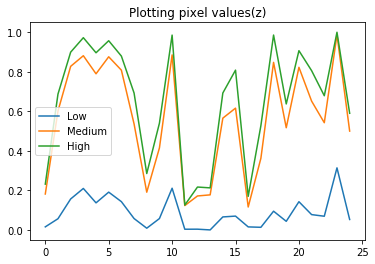

In [303]:
for n in range(N):
    plt.plot(range(sample_size), pixel_values[n], label=labels[n])
plt.gca().legend(('Low', 'Medium', 'High'))

plt.title('Plotting pixel values(z)')

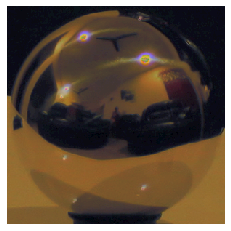

In [266]:
hdr_img = read_hdr_image('images/outputs/my_estimated_hdr.hdr')
display_hdr_image(hdr_img)

#### Irradiance Discussion (5 points)

(5 points) Under a heading "Irradiance Discussion", explain for each of the three methods (naive, exposure correction, response function estimation) whether (or in what conditions) the irradiance images for different exposures should be similar. To help you answer, examine a few pixels across the various exposures. Remember that g(Z) = ln(t) + ln(E), where Z are pixel values and t is the exposure time in seconds. For the first two stages, we haven't estimated g, so you can assume g(Z) = ln(Z).

## Panoramic transformations (10 points)

Now that we have an HDR image of the spherical mirror, we'd like to use it for relighting (i.e. image-based lighting). However, many programs don't accept the "mirror ball" format, so we need to convert it to a different 360 degree, panoramic format (there is a nice overview of many of these formats here). For this part of the project, you should implement the mirror ball to equirectangular (latitude longitude) transformation. Most rendering software accepts this format, including Blender's Cycles renderer, which is what we'll use in the next part of the project.

To perform the transformation, you need to figure out the mapping between the mirrored sphere domain and the equirectangular domain. Hint: calculate the normals of the sphere (N) and assume the viewing direction (V) is constant. You can calculate reflection vectors with R = V - 2 * dot(V,N) * N, (NOTE that you'd have to implement channel-wise dot product). which is the direction that light is incoming from the world to the camera after bouncing off the sphere. The reflection vectors can then be converted to, providing the latitude and longitude (phi and theta) of the given pixel (fixing the distance to the origin, r, to be 1). Note that this assumes an orthographic camera (which is a close approximation as long as the sphere isn't too close to the camera). The view vector is assumed to be at (0,0,-1)

Next, the equirectangular domain can be created by making an image in which the rows correspond to theta and columns correspond to phi in spherical coordinates. For this we have provided you a function in the starter code get_equirectangular_image() (You can find the function under utils in hdr_helpers.py). The function takes reflection vectors and the HDR image produced in the Naive implementation as input and returns the equirectangular image as output.

Below is an example transformation.

<img src="images/project_4/panoramic_trans.jpg" width="500px">

Note that by choosing 360 as EH and 720 as EW, we are making every pixel in equirectangular image to correspond to area occupied by 0.5 degree x 0.5 degree in spherical coordinate.

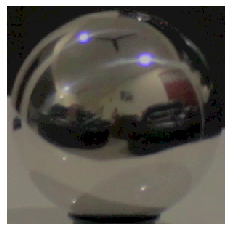

In [5]:
hdr_mirrorball_image = read_hdr_image('images/outputs/my_naive_hdr.hdr')
display_hdr_image(hdr_mirrorball_image)

In [6]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute normal vector from mirror ball
    2) Compute reflection vector of mirror ball using given equation
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
      - hint: use scipy.interpolate.griddata


    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert H % 2 == 0
    assert C == 3
    
    '''
    For Normal vector
        (u,v) => (Nx, Ny, Nz)
        Nx = (u - center)/(width/2)
        Ny = (v - center)/(height/2)
        
        Nx**2 + Ny**2 + Nz**2 = 1
        Nz = sqrt(1- Nx**2 - Ny**2)
    '''
    mid_y = int(H/2)
    mid_x = int(W/2)
    
    assert mid_y == mid_x
    
    N = np.zeros((H,W,3))
    sphere_mask = np.ones((H,W,3))
    
    for y in range(H):
        for x in range(W):
            distance = np.sqrt( ( y-mid_y)**2 + (x-mid_x)**2 )
            
            # outside sphere
            if(distance > mid_y):
                N[x][y] = (0,0,0)
                sphere_mask[x,y] = 0
                continue
            
            Nx = (x - mid_x)/ mid_x
            Ny = (y - mid_y)/ mid_y
            
            Nz = np.sqrt(1 - Nx**2 - Ny**2 )
    
            if (np.isnan(Nz)):
                Nz = 0
            
            #print("N ", Nx, Ny, Nz)
            
            N[y][x] = (Nx, Ny, Nz)
       
    print("N min:", N.min(), " max: ", N.max() )
    
    
    '''
    Calculate Reflection vector
            R = V - 2 * np.dot(V,N) * N
    '''
    V = [0,0,-1]   
    R = np.zeros((H,W,3))
    
    for x in range(H):
        for y in range(W):
            R[x][y] = V - 2 * np.dot(V,N[x][y]) * N[x][y]
    
    print("R min:", R.min(), " max: ", R.max() )

        
    equirectangular_image, phi, theta, equi1 = get_equirectangular_image(R, hdr_image)
    phi /= 2 * np.pi
    theta /= np.pi
    
    phi_theta_ball_T = np.zeros((3,W,H))
    phi_theta_ball_T[0] = np.transpose(phi)[0]
    phi_theta_ball_T[1] = np.transpose(theta)[0]               
    phi_theta_ball = np.transpose(phi_theta_ball_T)
    
    phi_theta = np.zeros((H,W,3))
    
    for y in range(H):
        for x in range(W):
            phi_theta[y][x][0] = phi[y][x][0]
            phi_theta[y][x][1] = theta[y][x][0]
    
    phi_theta *= sphere_mask
    
    print('phi: ', phi.shape, ' min: ', phi.min(), 'max: ',phi.max(),\
          '\ntheta: ', theta.shape, 'min: ', theta.min(), 'max: ',theta.max())
    
    
    N_scaled = sphere_mask * ((N + 1)/2)
    #print("N_scaled min:", N_scaled.min(), " max: ", N_scaled.max() 
    
    R_scaled = sphere_mask * (R + 1)/2
    #print("R_Scaled min:", R_scaled.min(), " max: ", R_scaled.max() )
    
    display_images(3, [N_scaled, R_scaled, phi_theta], ['Normals', 'Reflection', 'Phi/Theta'])
    
    EH=360
    EW=720
    
    print("Equi_coord: ", equi1.shape, " equirectangular_image: ", equirectangular_image.shape)
    phi_theta_rescaled = np.zeros((EH,EW,3))
    
    
    for y in range(EH):
        for x in range(EW):
            phi_theta_rescaled[y][x][0] = equi1[y*x][0]
            phi_theta_rescaled[y][x][1] = equi1[y*x][1]
    
    print('phi_theta_rescaled: min: ', phi_theta_rescaled.min(), 'max: ',phi_theta_rescaled.max())
          
    #display_images(1, [phi_theta_rescaled],['Phi/theta equirectangular'])
    
    # To get smoother equirectangular, will not multiply phi by 3
    equirectangular_image2, phi, theta, equi2 = get_equirectangular_image(R, hdr_image, False)
    
    return equirectangular_image, equirectangular_image2, N, R

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


N min: -1.0  max:  1.0
R min: -1.0  max:  1.0
phi:  (300, 300, 1)  min:  0.0 max:  0.997877918372787 
theta:  (300, 300, 1) min:  0.0003961190716811145 max:  0.9996038809283189
Equi_coord:  (259200, 2)  equirectangular_image:  (360, 720, 3)
phi_theta_rescaled: min:  0.0 max:  6.27445866091958


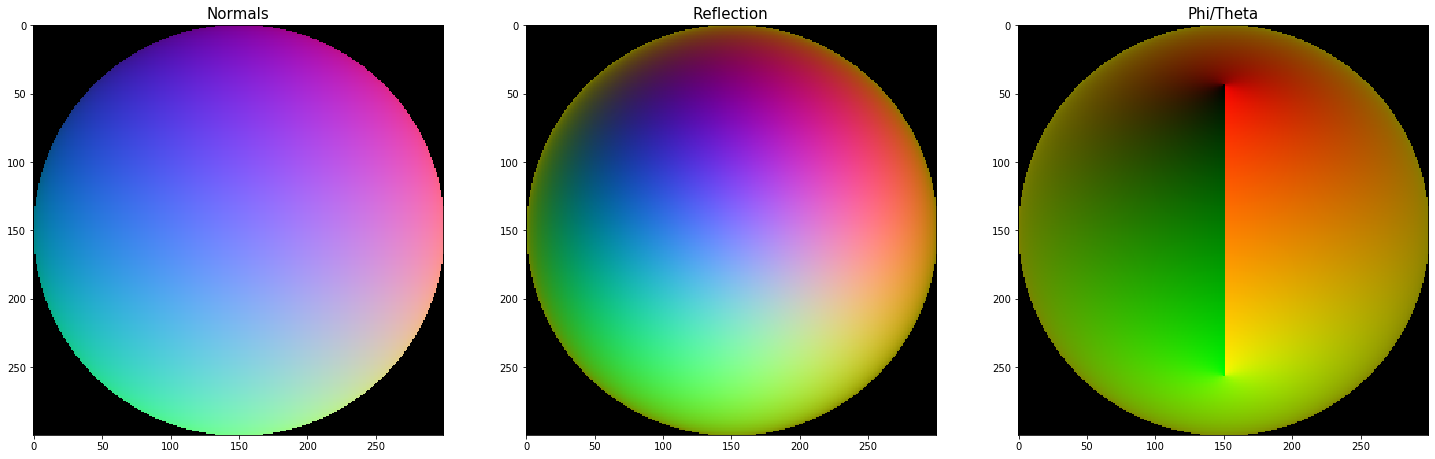

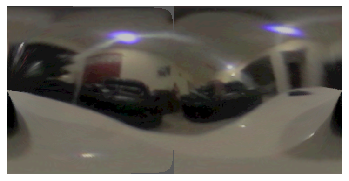

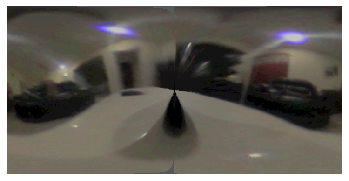

In [7]:
eq_image, eq_image2, normals, reflection = panoramic_transform(hdr_mirrorball_image)
display_hdr_image(eq_image)
display_hdr_image(eq_image2)

write_hdr_image(eq_image, 'images/outputs/my_equirectangular1.hdr')
write_hdr_image(eq_image2, 'images/outputs/my_equirectangular2.hdr')

In [22]:
#eq_image = read_hdr_image("images/outputs/my_equirectangular.hdr")
#display_hdr_image(eq_image)

---

## Rendering synthetic objects into photographs (30 pts)

Next, we will use our equirectangular HDR image as an image-based light, and insert 3D objects into the scene. This consists of 3 main parts: modeling the scene, rendering, and compositing. Specific instructions follow below; if interested, see additional details in Debevec's paper. 

Begin by downloading/installing the Blender. This template assumes that you have version 2.8 of the blender; if you are using version 2.7x, please refer to project webpage for detailed steps. The course webpage has tutorial with sample blend file, while this tutorial assumes that you create your own blend file from scratch. Please right click, open in new tab to view GIFs in full size.


### Modeling the scene

To insert objects, we must have some idea of the geometry and surface properties of the scene, as well as the lighting information that we captured in previous stages. In this step, you will manually create rough scene geometry/materials using Blender.

First clear out initial scene including sample mesh and lighting.
<img src="images/project_4/1_delete_initial.gif" width="720px">

Next, set camera to correct position
<img src="images/project_4/2_set_camera_position.gif" width="720px">

Next, go into perspective camera mode.
<img src="images/project_4/3_go_into_camera.gif" width="720px">

Then, setup viewport dimension. You want the same dimension as your background image for this.
<img src="images/project_4/4_setup_dimensions.gif" width="720px">


We then want to load background image onto this viewport. Click on 'g' to move background image around, and 's' to resize it.
<img src="images/project_4/5_load_background_and_align.gif" width="720px">

Then, we want to add local scene. That is, add simple geometry (usually planes suffice) to recreate the geometry in the scene near where you'd like to insert objects. For best results, this should be close to where you placed the spherical mirror. Feel free to use the sample scene provided and move the vertices of the plane to match the surface you'd like to recreate (ignore the inserted bunny/teapot/etc for now). Once you're happy with the placement, add materials to the local scene: select a piece of local scene geometry, go to Properties->Materials, add a Diffuse BSDF material, and change the "Color" to roughly match the color from the photograph.
<img src="images/project_4/6_adding_plane.gif" width="720px">
<img src="images/project_4/7_setting_plane_material.gif" width="720px">
Insert synthetic objects into the scene. Feel free to use the standard models that I've included in the sample blend file, or find your own (e.g. Turbosquid, Google 3D Warehouse, DModelz, etc). Add interesting materials to your inserted objects as well. This tutorial is a great introduction to creating materials in Blender. Once finished, your scene should now look something like the right image below.
<img src="images/project_4/8_adding_mesh.gif" width="720px">
<img src="images/project_4/9_set_mesh_material.gif" width="720px">
Then, add your HDR image (the equirectangular map made above) to the scene.

First, use notebook to save the HDR panorama: write_hdr_image(eq_image, 'equirectangular.hdr'). 

In the World tab on property panel, make sure Surface="Background" and Color="Environment Texture". Locate your saved HDR image in the filename field below "Environment Texture".
<img src="images/project_4/10_add_equirectangular_lighting.gif" width="720px">

Finally, render scene using 'cycle' renderer. Note that this step takes a while to run.
<img src="images/project_4/11_render_cycles.gif" width="720px">


Once you've finished rendering scene with object, you should save it using image > save functionality in render tab.


You also need to create 'empty' scene without inserted objects, and mask for added objects.
To render masked scene, remove equirectangular based lighting, and set all inserted objects' material to emission.
You can render the mask by using 'Eevee' renderer


<img src="images/project_4/12_save_mask.gif" width="720px">

With all rendered images, you should have there three images, (rendered with object, without object, and mask):

<img src="images/project_4/render_render.jpg" width="200px" style="display: inline">
<img src="images/project_4/render_empty.jpg" width="200px" style="display: inline">
<img src="images/project_4/render_mask.jpg" width="200px" style="display: inline">

In [17]:
background_image_file = "images/inputs/IMG_1_BG.JPG"
background_with_probe_image_file = "images/inputs/IMG_1_with_probe.JPG"


In [18]:
I = read_image(background_image_file)
P = read_image(background_with_probe_image_file)

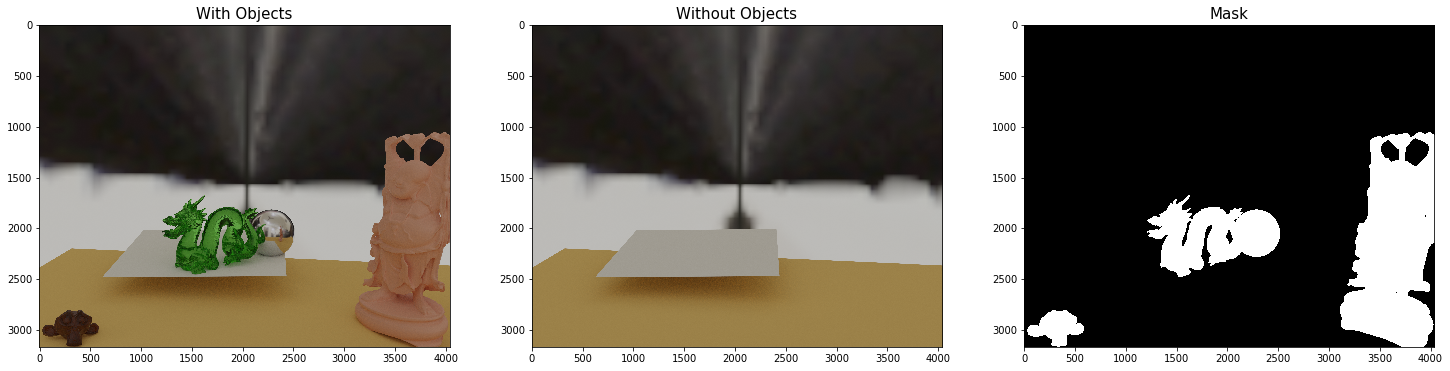

In [19]:
# this part assumes that you have these from Blender.
blender_output_with_object_path = "images/outputs/R_with_objects.png"
blender_output_without_object_path = "images/outputs/E_without_objects.png"
blender_output_mask_path = "images/outputs/M_mask.png"

O = read_image(blender_output_with_object_path)
E = read_image(blender_output_without_object_path)
M = read_image(blender_output_mask_path)

M = M > 0.5

R = O
display_images(3, [O,E,M],['With Objects', 'Without Objects', 'Mask'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


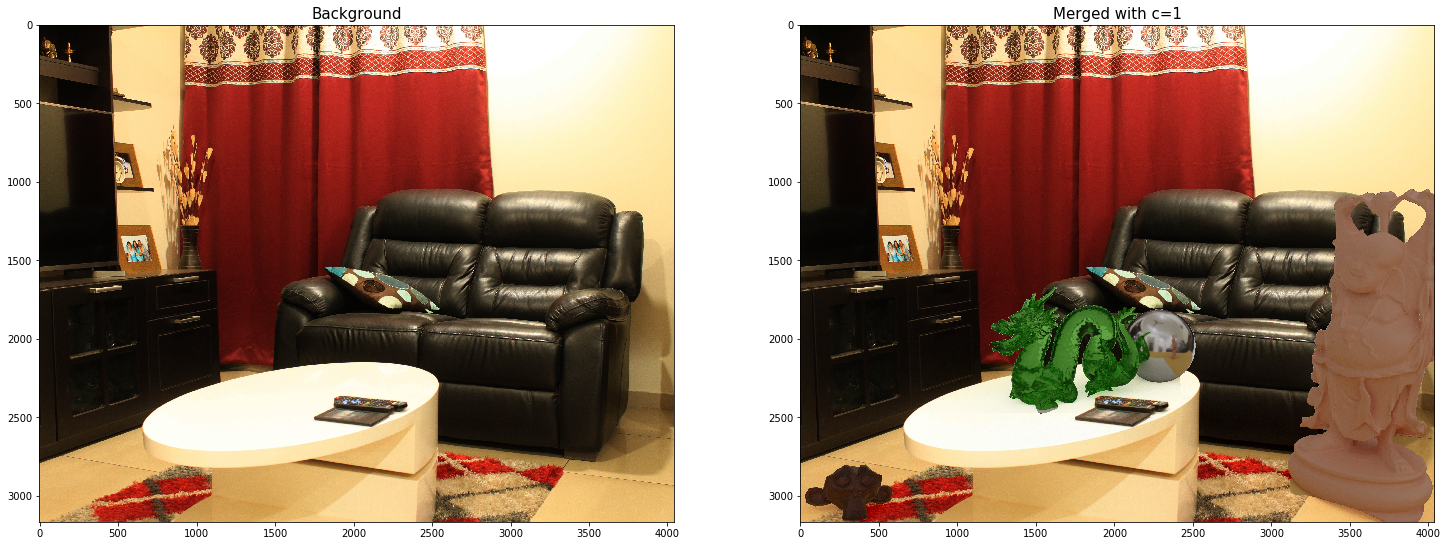

In [20]:
c=1.0
merged = M*R + (1-M)*I + (1-M)*(R-E)*c

write_image(merged, 'images/outputs/merged.png')

display_images(2, [I,merged],['Background','Merged with c=1'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


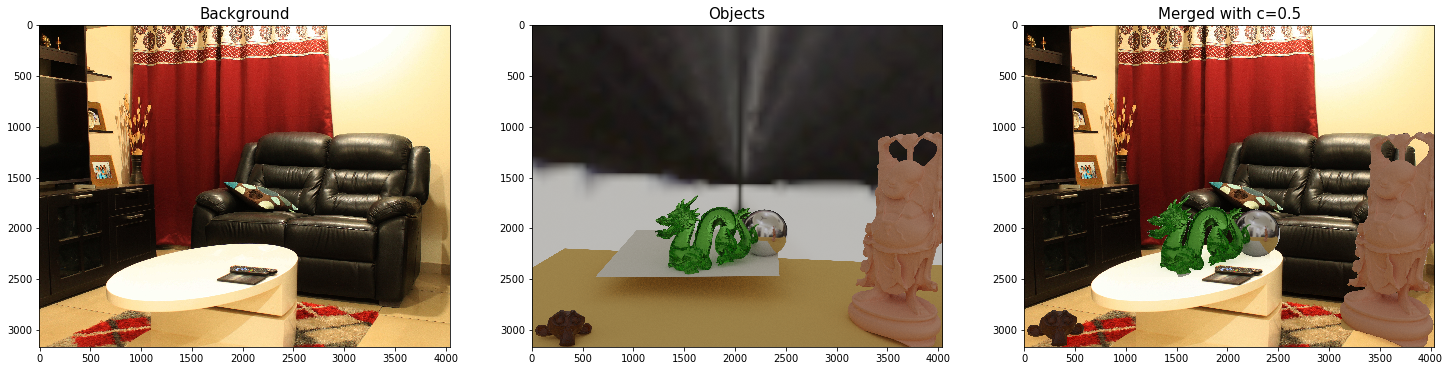

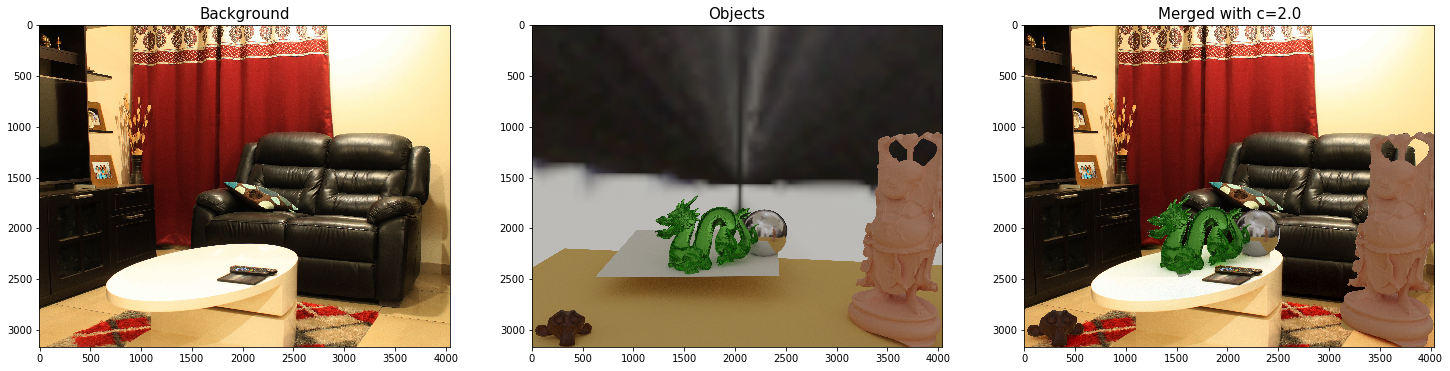

In [21]:
c=0.5
merged_2 = M*R + (1-M)*I + (1-M)*(R-E)*c
display_images(3, [I,R,merged_2],['Background','Objects','Merged with c='+str(c)])
write_image(merged_2, 'images/outputs/merged_2.png')

c=2.0
merged_3 = M*R + (1-M)*I + (1-M)*(R-E)*c
display_images(3, [I,R,merged_3],['Background','Objects','Merged with c='+str(c)])
write_image(merged_3, 'images/outputs/merged_3.png')

---

## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result (20 pts)
Give an image-based lighting result with new objects with the same HDR light map (10 points). Compositing a result with a new HDR light map (10 more points). There are a total of 20 possible points here. 



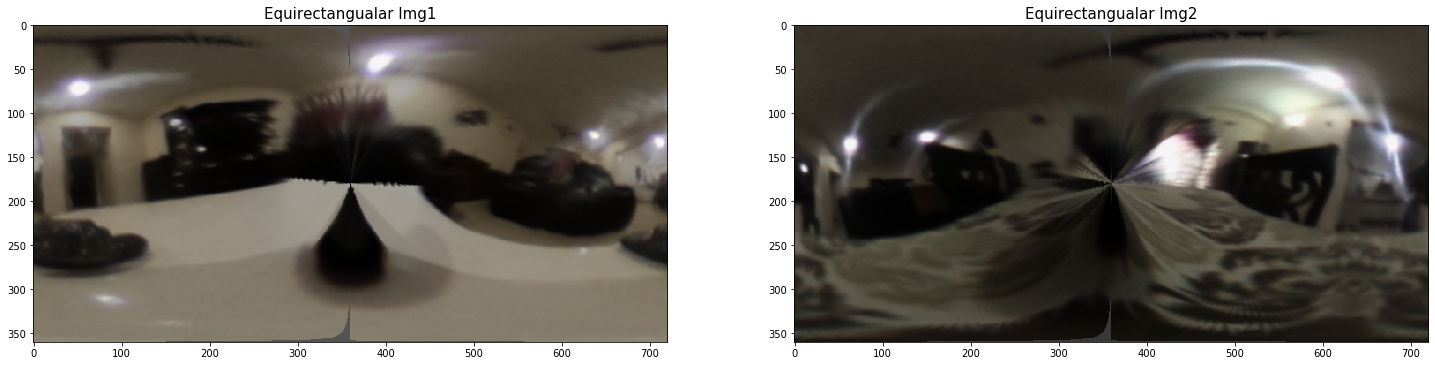

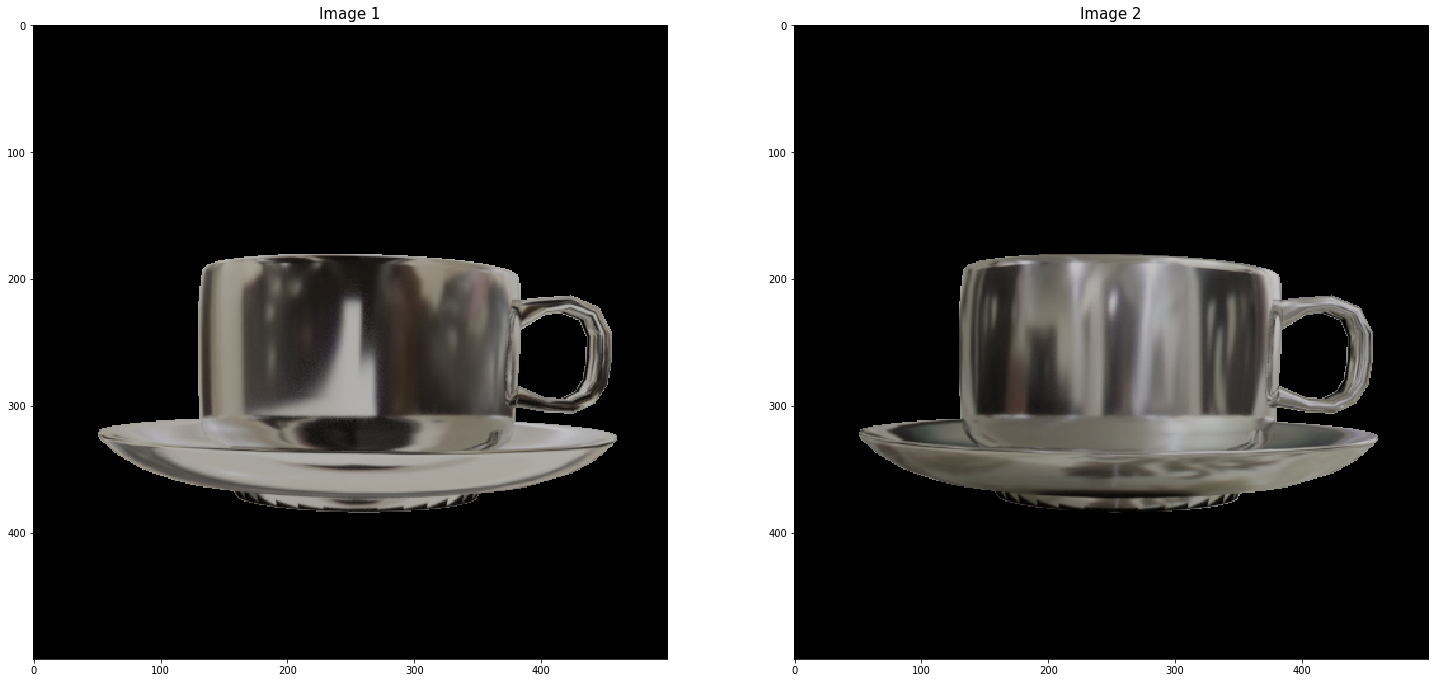

In [23]:
mask_file = "images/outputs/cup-mask.png"

mask = read_image(mask_file)
mask = mask > 0.5

eq_imgs = []

eq_imgs.append(read_image("images/outputs/my_equirectangular_1_2.hdr"))
eq_imgs.append(read_image("images/outputs/my_equirectangular_2_2.hdr"))

display_images(2, eq_imgs, ['Equirectangualar Img1', 'Equirectangualar Img2'])

out_imgs = []
titles = []
i = 1
while (i < 3):
    img_file = "images/outputs/cup-" + str(i) +".png"
    img = read_image(img_file)
    output = img * mask 
    out_imgs.append(output)
    titles.append('Image ' + str(i))
    i += 1

display_images(2, out_imgs, titles)


### Other panoramic transformations (20 pts) 
Different software accept different spherical HDR projections. In the main project, we've converted from the mirror ball format to the equirectangular format. There are also two other common formats: angular and vertical cross (examples here). Implement these transformations for 10 extra points each (20 possible).


### Photographer/tripod removal (20 pts) 
If you look closely at your mirror ball images, you'll notice that the photographer (you) and/or your tripod is visible, and probably occupies up a decent sized portion of the mirror's reflection. For 20 extra points, implement one of the following methods to remove the photographer: 
  1. Cut out the photographer and use in-painting/hole-filling to fill in the hole with background pixels (similar to the bells and whistles from Project 2), or 
  2. Use Debevec's method for removing the photographer (outlined here, steps 3-5; feel free to use Debevec's HDRShop for doing the panoramic rotations/blending). 

The second option works better, but requires you to create an HDR mirror ball image from two different viewpoints, and then merge them together using blending and panoramic rotations.


### Local tonemapping operator (30 pts) 
HDR images can also be used to create hyper-realistic and contrast enhanced LDR images. This paper describes a simple technique for increasing the contrast of images by using a local tonemapping operator, which effectively compresses the photo's dynamic range into a displayable format while still preserving detail and contrast. For 30 extra credit points, implement the method found in the paper and compare your results to other tonemapping operations (see example below for ideas). You can use bilateral_filter code, provided by us, in your implementation, but do not use any other third party code. You can find some example HDR images here, including the memorial church image used below.

<img src="images/project_4/local_tonemap.jpg" width="800px">
From left to right: simple rescaling, rescaling+gamma correction, local tonemapping operator, local tonemapping+gamma correction.


HDR min:  0.0  max:  274.0  dtype:  float32


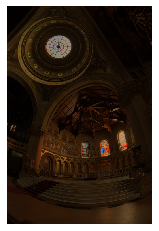

In [4]:
image_file = 'images/inputs/memorial.hdr'
original_image = read_hdr_image(image_file)
print('HDR min: ', original_image.min(), ' max: ', original_image.max() , ' dtype: ', original_image.dtype )

display_hdr_image(original_image)


Rescaled HDR min:  0.0  max:  255.0  dtype:  float32


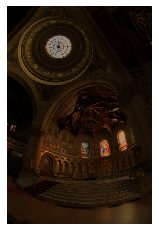

In [5]:
rescaled_image = (original_image/original_image.max()*255)
print('Rescaled HDR min: ', rescaled_image.min(), ' max: ', rescaled_image.max(), ' dtype: ', rescaled_image.dtype)
                                                          
display_hdr_image(rescaled_image)

write_hdr_image(rescaled_image, 'images/outputs/memorial_rescaled.hdr')


In [6]:
def reinhart_operator(hdr_image: np.ndarray) -> np.ndarray:
    H,W,C = hdr_image.shape
    
    new_image = np.ndarray((H,W,C))
    for y in range(H):
        for x in range(W):
            for c in range(C):
                new_image[y][x][c] = hdr_image[y][x][c]/(1+hdr_image[y][x][c])
                
    return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reinhart min:  0.0  max:  0.9963636363636363  dtype:  float64


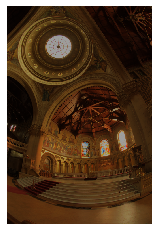

In [7]:
reinhart_image = reinhart_operator(original_image)
print('Reinhart min: ', reinhart_image.min(), ' max: ', reinhart_image.max(), ' dtype: ', reinhart_image.dtype)

display_hdr_image(reinhart_image)

write_hdr_image(reinhart_image, 'images/outputs/memorial_reinhart.hdr')

In [10]:
def apply_gaussian_filter(im, size, sigma):
    low_pass_filtered = cv2.GaussianBlur(im, (size, size), sigma)

    return low_pass_filtered

def laplacian_filter(im, size, sigma):
    
    low_pass_filtered = apply_gaussian_filter(im, size, sigma)
    high_pass_filtered = np.subtract(im, low_pass_filtered)
    
    return high_pass_filtered

def apply_laplacian_filter(im, size, sigma):
    laplacian_filtered = np.zeros(im.shape, im.dtype)
    
    if(len(im.shape) > 2):
        im_r, im_g, im_b = cv2.split(im)
        filtered = np.zeros((3,im.shape[0],im.shape[1]), im.dtype)
        
        filtered[0] = laplacian_filter(im_r, size, sigma)
        filtered[1] = laplacian_filter(im_g, size, sigma)
        filtered[2] = laplacian_filter(im_b, size, sigma)
        laplacian_filtered = cv2.merge((filtered[0],filtered[1],filtered[2]))
    else:
        laplacian_filtered = laplacian_filter(im, size, sigma)
    
    #display_images(2, [im, laplacian_filtered], ['Original', 'High pass filtered'],['double','double'])
    
    return laplacian_filtered

In [44]:
def apply_bilateral_filter(hdr_image: np.ndarray) -> np.ndarray:
    
    h, w, c = hdr_image.shape
     
    r_data, g_data, b_data = cv2.split(hdr_image)
    
    sigma_spatial = min(w,h)/64
    
    laplacian = apply_laplacian_filter(hdr_image, 5, sigma_spatial)
    
    display_images(2, [hdr_image, laplacian],['Image', 'Laplacian'])
            
    r_edges, g_edges, b_edges = cv2.split(laplacian)
    
    print('sigma: ', sigma_spatial, 'edge min:', laplacian.min(), ' max:', laplacian.max())
      
    # Cross bilateral filter
    print('Processing R channel')
    r_bilateral = bilateral_filter(r_data, r_edges, r_data.min(), r_data.max(), sigma_spatial)
    
    print('Processing G channel')
    g_bilateral = bilateral_filter(g_data, g_edges, g_data.min(), g_data.max(), sigma_spatial)
    
    print('Processing B channel')
    b_bilateral = bilateral_filter(b_data, b_edges, b_data.min(), b_data.max(), sigma_spatial)
    
    print('Merging channels')
    bilateral_image = cv2.merge((r_bilateral,g_bilateral,b_bilateral))

    display_images(3, [r_data, r_edges, r_bilateral ],['R channel','Edges','Bilateral'])
    display_images(3, [g_data, g_edges, g_bilateral ],['G channel','Edges','Bilateral'])
    display_images(3, [b_data, b_edges, b_bilateral ],['B channel','Edges','Bilateral'])
    
    merged = laplacian + bilateral_image
    display_images(4, [hdr_image, laplacian, bilateral_image, merged],['Image', 'Laplacian', 'Bilateral', 'Bilaternal+Laplacian'])
   
    return merged

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sigma:  8.0 edge min: -77.038605  max: 169.18446
Processing R channel
Processing G channel
Processing B channel
Merging channels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


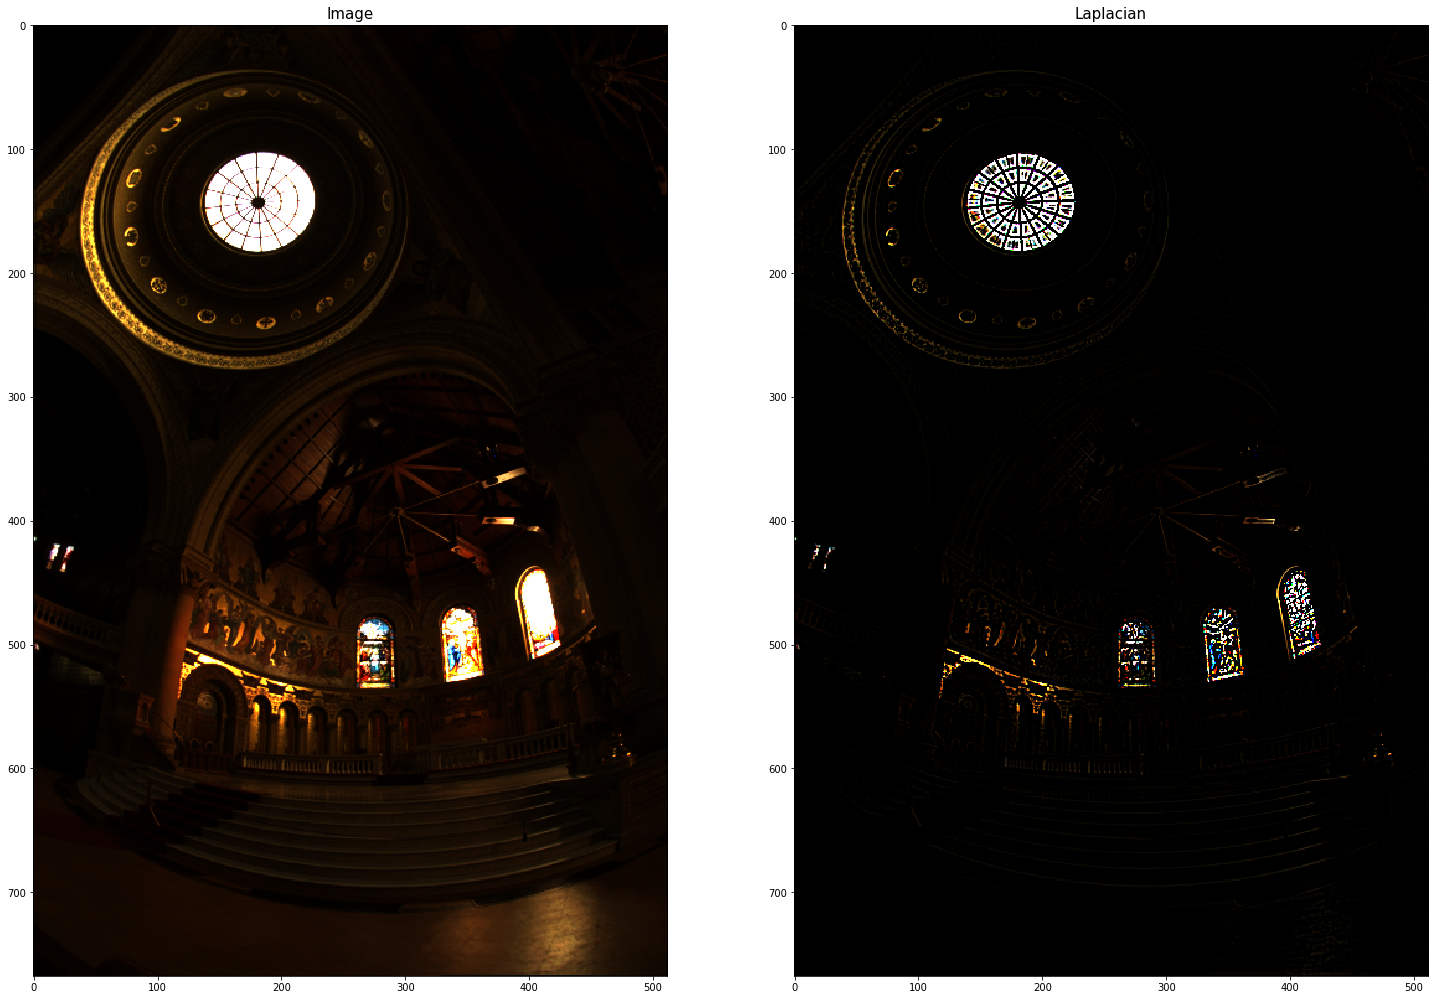

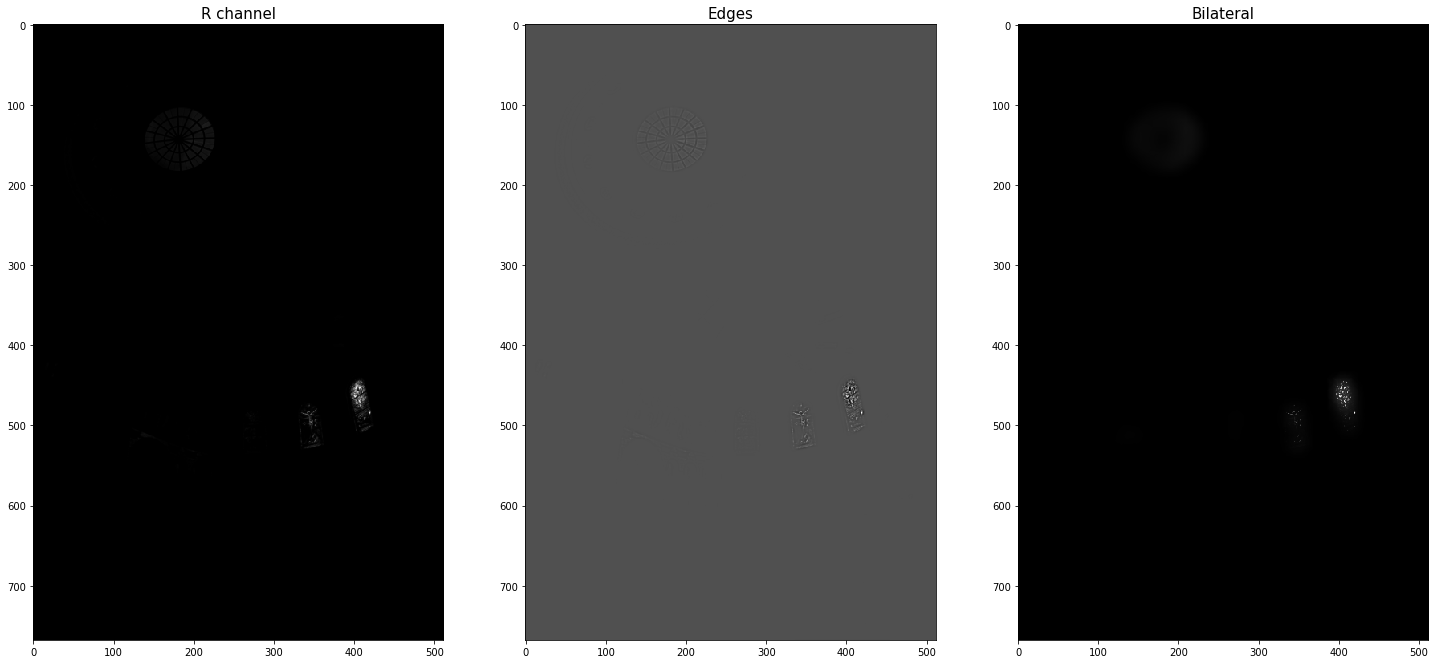

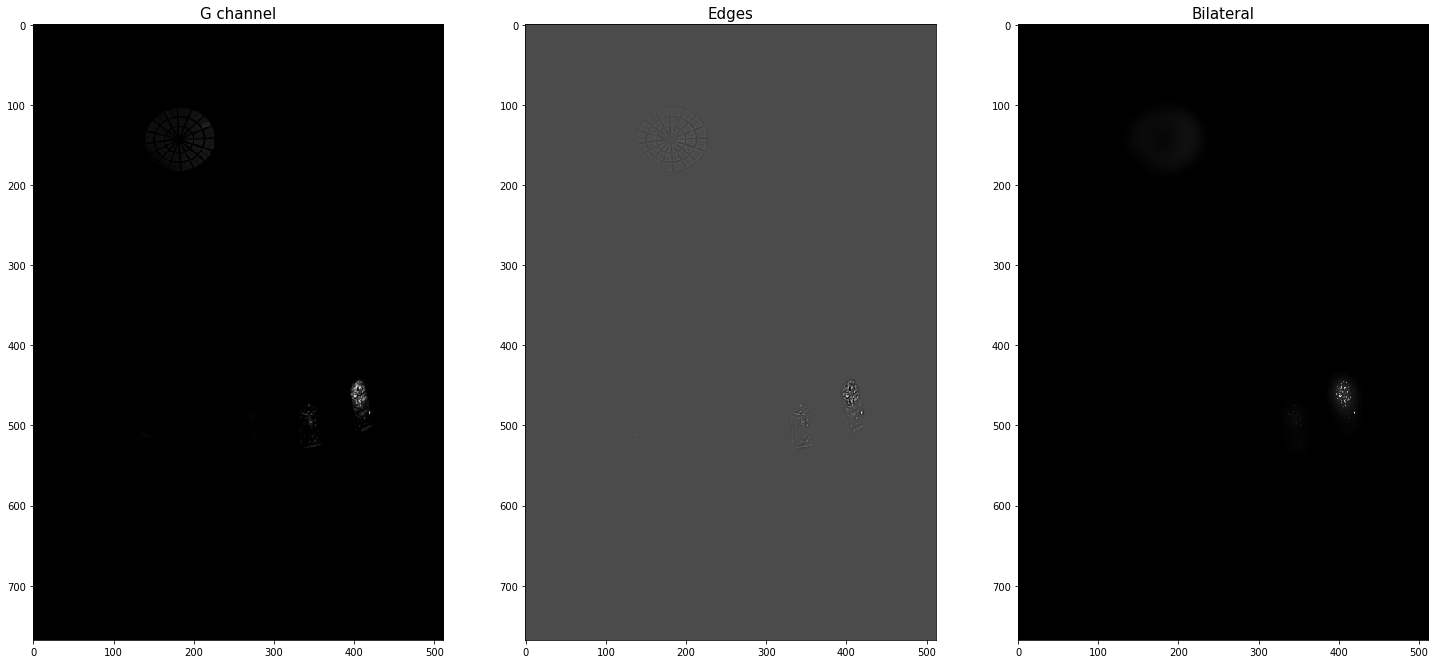

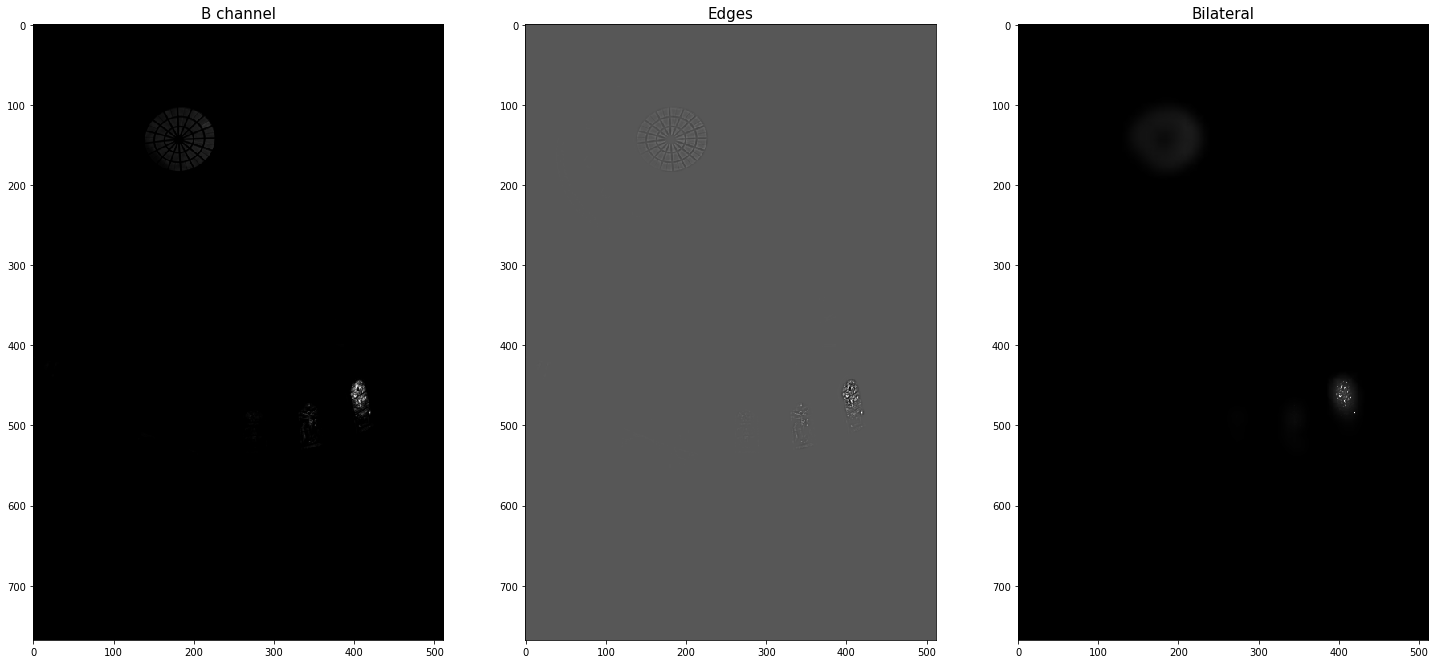

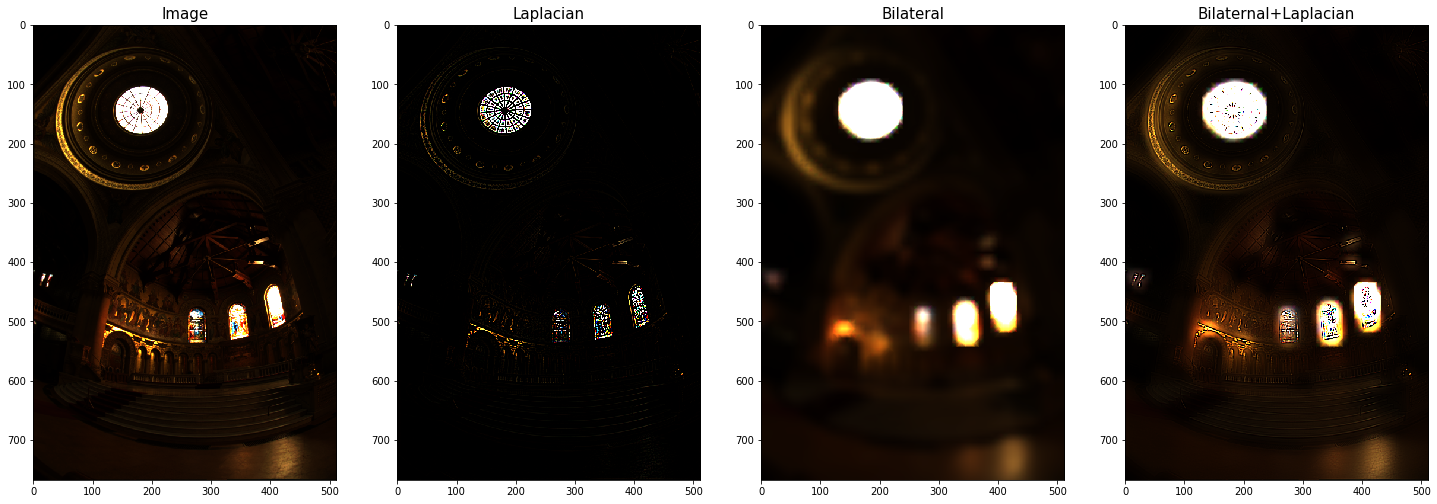

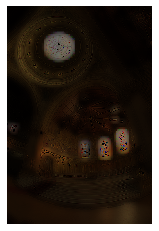

In [45]:

bilateral_hdr_image = apply_bilateral_filter(rescaled_image)
display_hdr_image(bilateral_hdr_image)

write_hdr_image(bilateral_hdr_image, 'images/outputs/memorial_bilateral.hdr')

In [475]:
def gammaCorrection(im, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype(np.uint8)
    # apply gamma correction using the lookup table
    im_enh = cv2.LUT(im, table)
    return im_enh


Gamma Corrected min:  0  max:  255  dtype:  uint8
Gamma Correction with 2.0


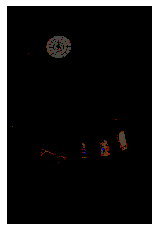

In [501]:
gamma_value = 2.0

gamma_corrected_hdr = gammaCorrection(rescaled_image.astype('uint8'), gamma_value)
print('Gamma Corrected min: ', gamma_corrected_hdr.min(), ' max: ', gamma_corrected_hdr.max(), ' dtype: ', gamma_corrected_hdr.dtype)

print('Gamma Correction with ' + str(gamma_value))

display_hdr_image(gamma_corrected_hdr)

write_hdr_image(rescaled_image, 'images/outputs/memorial_gamma_corrected.hdr')


In [502]:
def gainAndBiasAdjustment(im, alpha, beta):
    
    # Alpha range  1.0 - 3.0 (Constrast Control)
    # Beta range0-100 (Brightness Control) 
    
    im_enh = np.zeros(im.shape, im.dtype)
    im_enh = cv2.convertScaleAbs(im, alpha=alpha, beta=beta)
    
    return im_enh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


gain_adjustment  min:  100  max:  255  dtype:  uint8


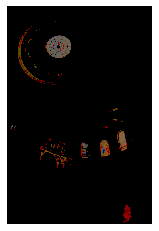

In [503]:
alpha = 1.0
beta = 100

gain_bias_adjustment = gainAndBiasAdjustment(original_image, alpha, beta)
print('gain_adjustment  min: ', gain_bias_adjustment.min(), ' max: ', gain_bias_adjustment.max(), ' dtype: ', gain_bias_adjustment.dtype)


display_hdr_image(gain_bias_adjustment)

write_hdr_image(rescaled_image, 'images/outputs/memorial_gain_bias.hdr')
